In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import talib as ta
from statsmodels.tsa.stattools import adfuller


In [103]:
listOfTickers = ['AAPL', 'AMT', 'AMZN', 'BAC', 'BA',
                 'BLK', 'BRKA', 'CAT', 'COST', 'CSCO',
                 'CVX', 'DUK', 'FCX', 'GOOGL', 'HD', 
                 'ISRG', 'JNJ', 'JPM', 'KO',
                 'LLY', 'MCD', 'MSFT', 'META', 'NEE',
                 'NFLX', 'NKE', 'NUE', 'NVDA', 'ORCL',
                 'PG', 'PLD', 'RTX', 'SLB', 'SO', 
                 'SPG', 'T', 'UNH', 'UNP', 'WMT', 
                 'XOM']


In [104]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [105]:
dataframes = []
for ticker in listOfTickers:
    # Read CSV
    df = pd.read_csv(f'../data/raw/{ticker}.csv')
    
    df.columns = df.columns.str.lower()
    df.rename(columns={'close/last': 'close'}, inplace=True)
    df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
    
    # Remove dollar signs and convert to float
    columnsWithDollarSign = ['close', 'open', 'high', 'low']
    for column in columnsWithDollarSign:
        df[column] = df[column].str.replace('$', '', regex=False).astype(float)
    
    df['ticker'] = ticker

    # Sort by date
    df.sort_values(by='date', ascending=True, inplace=True)

    df['returns'] = df['close'].pct_change()
    df['returns'] = df['returns'].shift(-1)
    # df['log_returns'] = np.log(df['returns'] + 1)

    # Add technical indicators

    # # Momentum Indicators
    df['rsi'] = ta.RSI(df['close'], timeperiod=14)
    df['kama'] = ta.KAMA(df['close'], timeperiod=10)
    # df['hlc3'] = (df['high'] + df['low'] + df['close']) / 3

    # Trend Indicators
    df['ema'] = ta.EMA(df['close'], timeperiod=10)
    df['tema'] = ta.TEMA(df['close'], timeperiod=10)

    # # Volatility Indicators
    # df['atr'] = ta.ATR(df['high'], df['low'], df['close'], timeperiod=14)
    # df['bb_upper'], df['bb_middle'], df['bb_lower'] = ta.BBANDS(df['close'], timeperiod=10, nbdevup=1.5, nbdevdn=1.5, matype=0)

    # Volume Indicators
    df['mfi'] = ta.MFI(df['high'], df['low'], df['close'], df['volume'], timeperiod=10)
    df['obv'] = ta.OBV(df['close'], df['volume'])

    df.dropna(inplace=True)
    
    # Store in dictionary
    dataframes.append(df)

In [106]:
df = pd.concat(dataframes, ignore_index=True)

In [107]:
df

,date,close,volume,open,high,low,ticker,returns,rsi,kama,ema,tema,mfi,obv
0,2015-12-23,27.1525,130472560,26.8175,27.2125,26.8000,AAPL,-0.005340,41.899128,27.541394,27.504445,26.761478,18.818790,-573985480.0
1,2015-12-24,27.0075,54386720,27.2500,27.2500,26.9875,AAPL,-0.011201,40.616972,27.461440,27.414092,26.774391,15.911017,-628372200.0
2,2015-12-28,26.7050,106559720,26.8975,26.9225,26.5452,AAPL,0.017974,38.004155,27.368836,27.285166,26.664920,16.684601,-734931920.0
3,2015-12-29,27.1850,123649040,26.7400,27.3575,26.7150,AAPL,-0.013059,44.144184,27.360072,27.266954,26.825755,25.161975,-611282880.0
4,2015-12-30,26.8300,100736360,27.1450,27.1750,26.7950,AAPL,-0.019195,40.916589,27.338830,27.187508,26.786950,26.994879,-712019240.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99435,2025-11-05,113.6800,12400920,114.0900,115.1800,113.6700,XOM,0.007213,49.590064,114.245022,114.280156,114.103307,38.528294,-116805389.0
99436,2025-11-06,114.5000,14219650,113.6400,114.9350,113.6400,XOM,0.023755,52.849917,114.253144,114.320128,114.215942,38.072675,-102585739.0
99437,2025-11-07,117.2200,17181150,115.2100,117.5050,114.9000,XOM,0.008531,61.697898,114.344278,114.847377,115.526101,48.320808,-85404589.0
99438,2025-11-10,118.2200,13047960,117.4400,118.4500,115.4550,XOM,0.013196,64.346858,114.493968,115.460581,116.847265,56.771834,-72356629.0


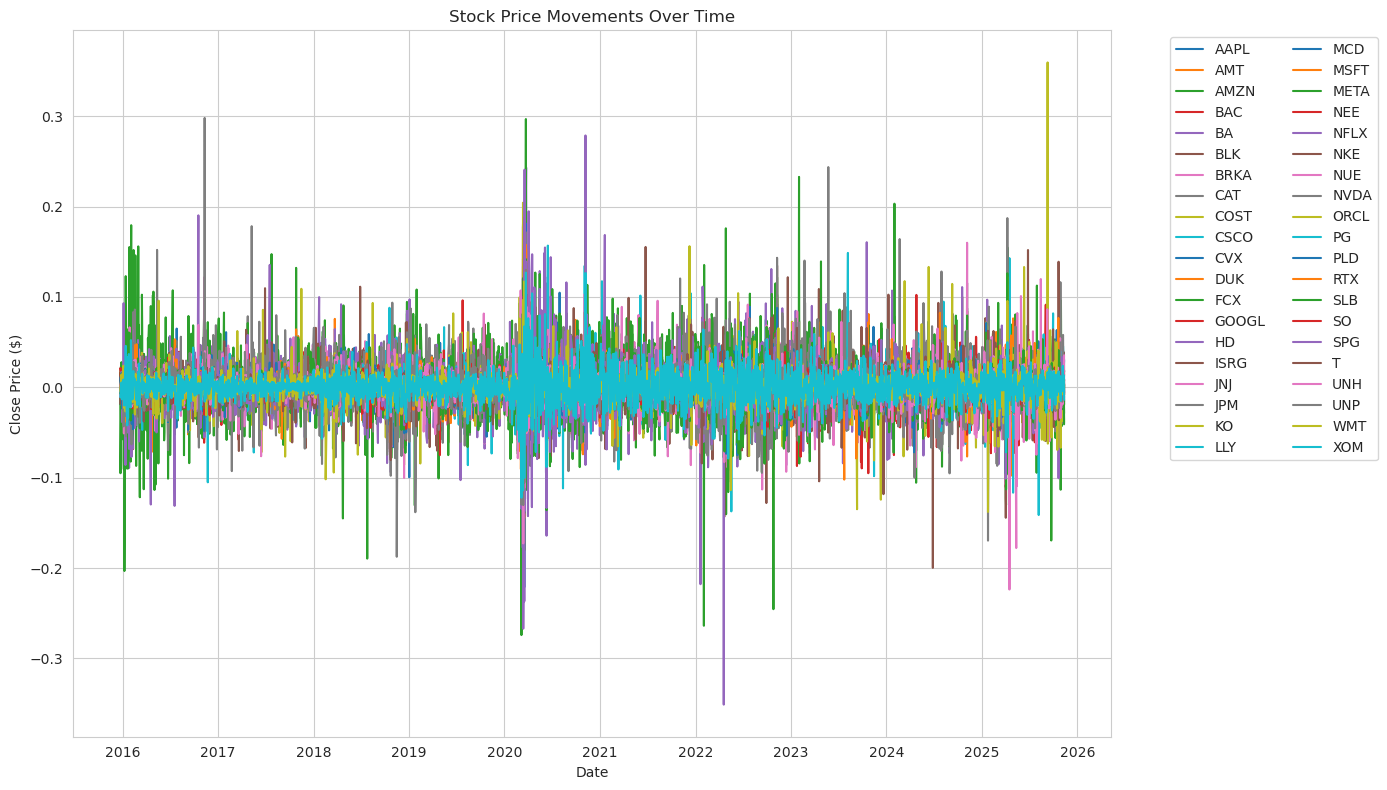

In [108]:
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

for ticker in listOfTickers:
    ticker_data = df[df['ticker'] == ticker]
    sns.lineplot(data=ticker_data, x='date', y='returns', label=ticker)

plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.title('Stock Price Movements Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.tight_layout()
plt.show()

In [109]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[numeric_cols].corr()

,close,volume,open,high,low,returns,rsi,kama,ema,tema,mfi,obv
close,1.000000,-0.047206,0.999951,0.999963,0.999976,-0.001172,0.014316,0.999800,0.999880,0.999967,0.003186,-0.031691
volume,-0.047206,1.000000,-0.047207,-0.047200,-0.047216,0.015456,0.025584,-0.047217,-0.047212,-0.047206,0.012170,0.709459
open,0.999951,-0.047207,1.000000,0.999962,0.999974,-0.001149,0.013907,0.999823,0.999899,0.999968,0.002970,-0.031692
high,0.999963,-0.047200,0.999962,1.000000,0.999951,-0.001155,0.014018,0.999814,0.999887,0.999957,0.003037,-0.031687
low,0.999976,-0.047216,0.999974,0.999951,1.000000,-0.001164,0.014221,0.999799,0.999880,0.999968,0.003144,-0.031698
returns,-0.001172,0.015456,-0.001149,-0.001155,-0.001164,1.000000,-0.012962,-0.001125,-0.001115,-0.001151,-0.005937,0.014421
rsi,0.014316,0.025584,0.013907,0.014018,0.014221,-0.012962,1.000000,0.012114,0.012456,0.014186,0.736293,0.044130
kama,0.999800,-0.047217,0.999823,0.999814,0.999799,-0.001125,0.012114,1.000000,0.999960,0.999826,0.001359,-0.031700
ema,0.999880,-0.047212,0.999899,0.999887,0.999880,-0.001115,0.012456,0.999960,1.000000,0.999903,0.001524,-0.031696
tema,0.999967,-0.047206,0.999968,0.999957,0.999968,-0.001151,0.014186,0.999826,0.999903,1.000000,0.003294,-0.031691


In [110]:
df.head()

,date,close,volume,open,high,low,ticker,returns,rsi,kama,ema,tema,mfi,obv
0,2015-12-23,27.1525,130472560,26.8175,27.2125,26.8000,AAPL,-0.005340,41.899128,27.541394,27.504445,26.761478,18.818790,-573985480.0
1,2015-12-24,27.0075,54386720,27.2500,27.2500,26.9875,AAPL,-0.011201,40.616972,27.461440,27.414092,26.774391,15.911017,-628372200.0
2,2015-12-28,26.7050,106559720,26.8975,26.9225,26.5452,AAPL,0.017974,38.004155,27.368836,27.285166,26.664920,16.684601,-734931920.0
3,2015-12-29,27.1850,123649040,26.7400,27.3575,26.7150,AAPL,-0.013059,44.144184,27.360072,27.266954,26.825755,25.161975,-611282880.0
4,2015-12-30,26.8300,100736360,27.1450,27.1750,26.7950,AAPL,-0.019195,40.916589,27.338830,27.187508,26.786950,26.994879,-712019240.0


In [111]:
df.to_csv('../data/processed/stocks.csv', index=False)